# ASI Assignemnt


Name: BOUKHARY Alaa

## 1. Importing the Data
### Importing the Mnist dataset

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#importing the Mnist data-set
Mnist=pd.read_csv('fashion-mnist_test.csv')
Mnist.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
Mnist.columns
Mnist.drop(columns=Mnist.columns[0]).values.shape

(10000, 784)

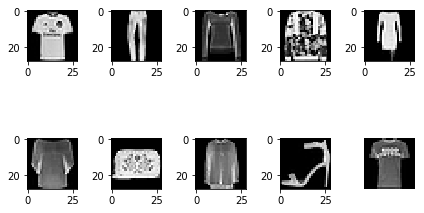

In [17]:

images=Mnist.drop(columns=Mnist.columns[0]).values
ROW = 2
COLUMN = 5
for i in range(ROW * COLUMN):
    
    image = np.array(images[i]).reshape(28, 28)   
    plt.subplot(ROW, COLUMN, i+1)          
    plt.imshow(image, cmap='gray')  
plt.axis('off')  
plt.tight_layout()  
plt.show()

### Importing the Cifar dataset

In [18]:
import os
import random
path='./cifar-10-batches-py/'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def get_data(file):
    absFile = os.path.abspath(path+file)
    dict = unpickle(absFile)
    X = np.asarray(dict[b'data'].T).astype("uint8")
    Yraw = np.asarray(dict[b'labels'])
    Y = np.zeros((10,10000))
    for i in range(10000):
        Y[Yraw[i],i] = 1
    names = np.asarray(dict[b'filenames'])
    return X.T,Y.T,names

def visualize_image(X,Y,names,id):
    rgb = X[id,:]

    img = rgb.reshape(3,32,32).transpose([1, 2, 0])

    plt.imshow(img)
    plt.title(names[id])


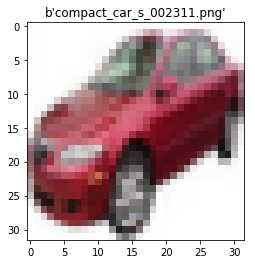

In [19]:
X=[]
Y=[]
names=[]
for i in range(1,6,1):
    X_temp,Y_temp,names_temp = get_data('data_batch_'+str(i))
    X_temp.shape
    X.extend(X_temp)
    Y.extend(Y_temp)
    names.extend(names_temp)
X=np.array(X)    
Y=Y=np.array(Y)
visualize_image(X,Y,names,random.randint(1,10000))

In [20]:
print("The shape of the image array is:",X.shape)
print("The shape of the labels array is:",Y.shape)

The shape of the image array is: (50000, 3072)
The shape of the labels array is: (50000, 10)


## 2. Distribution of our data

### Mnist dataset

In [7]:
#for label in Mnist.columns[0]:
Mnist.groupby('label').count()['pixel1']

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: pixel1, dtype: int64

### Cifar dataset

In [8]:

def study_distribution(y):
    distributions=np.zeros(y.shape[1])
    for element in y:
        for i in range(y.shape[1]):
            if(element[i]==1):
                distributions[i]+=1
    return distributions
study_distribution(Y)
                

array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000.])

### Answer

* we can see that the 2 datasets are highly balanced in fact the first one i.e. Mnist dataset is identically distributed between classes, while the second one is also highly balanced but not identically distributed which may result in a good accuracy for our predictions as imbalanced datasets is a huge problem in most training sets and most people try to balance them by using techniques such as oversampling the minority class or undersampling the majority calss.
* In the both datasets we have images as input data and eventhough they are low quality they still have many features (the value of each pixel) and as many classifiers have the assumption that features are independent variables having a high number of variables as input will increase the probability that this assumption is wrong as corrolation will appear between between these dimensions.

# 3. Classification
## a. Implementation of Naive Bayes Classifier

#### Algorithm:
* **Fitting on the training data:** this process invloves calculating the means and variances of each feature for using them later, and we calculate also in this step the priors for each class which is equal to the number of occurances of each class over the total occurances of all classes.
* **prediction:** In this step we calculate the log probabilty densities for each image to avoid numerical instabilities and we don't calculate the denomenator.


In [231]:
import scipy.stats
import collections
from scipy.stats import multivariate_normal


class ModifiedMultivariateNormal():
    def __init__(self,mean,std):
        # add a small epsiolon to standard deviations to remove standard deviations that are zero
        epsilon =  1e-9*std.max()
        std[:]=std[:]+epsilon
        self.std=std
        self.mean=mean
        
    def log_operations(self):
        feature=self.features
        mean=self.mean
        variance=self.std
        return np.sum(-np.divide(np.power((feature-mean),2),(2*variance))-np.log(np.sqrt(2*math.pi*variance)),axis=1)
    
    def calculate_pdf(self,x):
        self.features=x
        # claculate the log pdfs of the normal distributions to avoid numerical instabilities
        self.pdfs=self.log_operations()
        
    def get_pdf(self,index):
        return self.pdfs[index]
        
class NaiveBayes:
    def __init__(self):
        # initialise the Naive Bayes object
        self.features=[]
        self.labels=[]
        self.priors={}
        self.likelihoods={}
        self.results=[]
        self.test=[]
    def fit(self,X,Y):
        
        self.features=X
        self.labels=Y
        total_number=self.labels.shape[1]
        # calculating priors for each class
        for cls in range(self.labels.shape[1]):
            occurances=np.where(self.labels[:,cls]==1)
            self.priors[cls]=len(occurances)/total_number                
        # calculating the liklihood distributions for each class to be used later in predicting by inputting the feature values        
        for cls in range(self.labels.shape[1]):
            indexes=np.where(self.labels[:,cls]==1)
            mean=np.mean(self.features[indexes],axis=0)
            std=np.var(self.features[indexes],axis=0)
            self.likelihoods[cls]=ModifiedMultivariateNormal(mean,std)
                    
                    
    def predict(self,X):
        self.test=X
        self.results=np.zeros((self.test.shape[0],self.labels.shape[1]))
        for cls in range(self.labels.shape[1]):
            self.likelihoods[cls].calculate_pdf(self.test)
            
        for row in range(self.test.shape[0]):   
            for cls in range(self.labels.shape[1]):
                numerator=np.log(self.priors[cls])+self.likelihoods[cls].get_pdf(row)   
                self.results[row][cls]=numerator
        return self.results
    
    def classify(self):
        results=np.zeros((self.results.shape[0],self.results.shape[1]))
        # choose the class that has the highest posterior and set the rest classes to zero   
        for row in range(self.test.shape[0]):
            max_index=np.argmax(self.results[row,:]) 
            # if 2 classes have same posterior choose the 1st one
            if np.array(max_index).size==1:
                results[row][max_index]=1
            else: 
                results[row][max_index[0]]=1
        return results            

### b. Advantages and disadvantages

* **Disadvantage:** Naive Bayes classifier makes a huge assumption on the shape of the features that we have. For example I used in my implementation of Naive Bayes gaussian distribution for the features (pixels) and the algorithm assumes that the features are completely independent from each other which can't be true in this case i.e. when having images as input data since neighboring pixels for sure have are related which can affect the result.

* **Advantage:** While Naive Bayes has the huge disadvantage stated above it has a huge advantage on the other hand and that it's simple and fast due to it not being an iterative algorithm which is a main problem for powerful classifiers like deep networks where it will take hours for these classifiers to produce decent classifications while this classifier will produce a much faster result. The reason for it being fast is that all of its compuations invloves multiplcations and additions and it doesn't depend on iterative procedures where it needs to converge. 

### C.  Data Pre-processing 

Using the image datasets as is without preprocessing or preperation may result in weeker results so it is better to some work before training. One of the preprocessing techniques we can use:
* **Normalizing images**: our input images have pixel values in the range of [0-255] so it would result in some numerical instabilities, then it would be better if we can make them in the range of [0-1] and this can be done simply by subtrating the pixel values from the mean and deviding by stadard deviation so the distribution of the pixels will resemble a normal distribution with zero mean and 1 as standard deviaition.
* **Dimensionality reduction**: we may choose to callapse the rgb channels to a single gray-scale channel.
* **Data augmentation**: we may decide that we don't have enough data that can produce good results so we choose to artificially increase the amount of our data by doing creating new data from our existing data by doing simple tricks such as flipping (horizontal and vertical and both),rotation (90,180,270), scaling up and down.


###  Applying the Classifier to our data (parts d and e)

In [267]:
import math
def accuracy_score(y_test,y_pred):
    assert (y_test.shape[0]==y_pred.shape[0] and y_test.shape[1]==y_pred.shape[1])
    y_test_non_category = [ np.argmax(t) for t in y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y_pred]
    score=0 
    for i in range(y_test.shape[0]):            
        if y_test_non_category[i]==y_predict_non_category[i]:
            score=score+1
    return (score/y_test.shape[0])  
    
def log_loss(y_true,y_proba,epsilon=1e-15):
    y_test_non_category = [np.argmax(t) for t in y_test]
    log_loss=0
    for i in range(y_proba.shape[0]):
        if(y_proba[i][y_test_non_category[i]]<epsilon):
            
            log_loss-=math.log(epsilon)
        else:    
            log_loss-=math.log(y_proba[i][y_test_non_category[i]])
            #log_loss+=y_proba[i][y_test_non_category[i]]
    return log_loss/y_proba.shape[0]    

def confusion_matrix(y_true,y_pred):
    assert (y_test.shape[0]==y_pred.shape[0] and y_test.shape[1]==y_pred.shape[1])
    y_test_non_category = [np.argmax(t) for t in y_test]
    y_predict_non_category = [np.argmax(t) for t in y_pred]
    matrix=np.zeros((y_test.shape[1],y_test.shape[1]),dtype=np.int)
    for i in range(len(y_test_non_category)):
        matrix[y_test_non_category[i]][y_predict_non_category[i]]+=1
    return matrix 

#### MNIST Dataset

In [237]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(Mnist.drop(columns='label').values)

#features=Mnist.drop(columns='label').values
labels=pd.get_dummies(Mnist['label']).values

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
Naive=NaiveBayes()
Naive.fit(X_train,y_train)       
probabilities=Naive.predict(X_test)
predictions= Naive.classify()

print("the log-likelihood loss of the Naive Bayes classifier is :",log_loss(y_test, probabilities))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, predictions))
print("the confusion matrix of the mnist dataset is:\n",confusion_matrix(y_test , predictions))

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the logg-likelihood loss of the Naive Bayes classifier is : 938.7070614582198
The accuracy of the naive bayes classifier is : 0.5696
the confusion matrix of the mnist dataset is:
 [[131  13   9  58  34   0   2   0  14   0]
 [  0 236   1   4   1   0   2   0   0   0]
 [  0  10  64  24 124   0   2   0   4   0]
 [  1 101   1 139   7   0   2   0   0   0]
 [  0  20   9  45 184   0   0   0   1   0]
 [  0   0   0   1   0  51   1 157   3  10]
 [ 19  20  20  67 104   0   6   0  11   0]
 [  0   0   0   0   0   2   0 272   0   7]
 [  0   1   4  21  32   1   5   0 186   0]
 [  0   0   0   1   0   5   3  88   4 155]]


#### Cifar Dataset

In [238]:
minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(X)
#features=preprocessing.scale(X)
labels=Y

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
Naive=NaiveBayes()
Naive.fit(X_train,y_train)       
probabilities=Naive.predict(X_test)
predictions= Naive.classify()

print("the log-likelihood loss of the Naive Bayes classifier is :",log_loss(y_test, probabilities))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, predictions))
print("the confusion matrix of the cifar dataset is:\n",confusion_matrix(y_test , predictions))

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the logg-likelihood loss of the Naive Bayes classifier is : 368.12081964204566
The accuracy of the naive bayes classifier is : 0.28928
the confusion matrix of the mnist dataset is:
 [[568  44  44  18 110  49  71  17 268  81]
 [174 205  23  50 100 103 235  23 148 232]
 [257  30  89  23 374  43 257  26  59  48]
 [175  40  73 103 174 195 301  21  48  85]
 [123   9  69  39 532  50 312  22  61  47]
 [166  34  79  47 226 347 231  49  46  48]
 [120  12  56  22 315  62 575  22  27  45]
 [151  25  54  58 318 102 132 156  73 148]
 [241  53  18  20  63 111  63  11 556 107]
 [176 105  18  23  76  38 119  20 203 485]]


### f. Performance of the Classifier

The algorithm didn't perform well in general where it was slighly better than average in the first case and was completetly off with 0.28 accuracy in the second case.


Now Let's observe the performance of a random classifier and see if it performs better than this classifier:

In [270]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(Mnist.drop(columns='label').values)

#features=Mnist.drop(columns='label').values
labels=pd.get_dummies(Mnist['label']).values

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
predictions=np.zeros((y_test.shape[0],y_test.shape[1]))      
probabilities= np.random.rand(y_test.shape[0],y_test.shape[1])
#predictions[np.argmax(t) for t in probabilities]=1
indexes=[np.argmax(t) for t in probabilities]
predictions[np.arange(y_test.shape[0]),indexes]=1
print("the log-likelihood loss of the Naive Bayes classifier is :",log_loss(y_test, probabilities))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, predictions))
print("the confusion matrix of the mnist dataset is:\n",confusion_matrix(y_test , predictions))

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the logg-likelihood loss of the Naive Bayes classifier is : 1.0424196874498064
The accuracy of the naive bayes classifier is : 0.1024
the confusion matrix of the mnist dataset is:
 [[22 26 16 26 26 23 28 29 21 21]
 [32 24 20 22 14 19 29 24 27 25]
 [24 25 28 22 25 12 26 24 25 29]
 [27 26 28 22 26 25 33 28 21 26]
 [22 30 20 27 25 28 22 22 25 27]
 [25 24 20 20 29 21 22 31 22 27]
 [34 22 37 23 22 31 27 33 19 22]
 [23 24 26 24 27 29 27 21 32 29]
 [25 27 23 19 25 28 21 24 36 26]
 [22 23 19 18 24 35 27 31 20 30]]


In [272]:
minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(X)
labels=Y
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
predictions=np.zeros((y_test.shape[0],y_test.shape[1]))      
probabilities= np.random.rand(y_test.shape[0],y_test.shape[1])
indexes=[np.argmax(t) for t in probabilities]
predictions[np.arange(y_test.shape[0]),indexes]=1

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)


print("the log-likelihood loss of the Naive Bayes classifier is :",log_loss(y_test, probabilities))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, predictions))
print("the confusion matrix of the mnist dataset is:\n",confusion_matrix(y_test , predictions))

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


the logg-likelihood loss of the Naive Bayes classifier is : 0.992941593728725
The accuracy of the naive bayes classifier is : 0.09944
the confusion matrix of the mnist dataset is:
 [[132 139 136 105 144 130 146 127 125 125]
 [126 116 121 139 105 141 133 141 121 110]
 [135 140 129 107 109 105 119 134 121 110]
 [117 150 128 119 125 146 138 130 140 128]
 [111 122 147 128  99 122 110 131 124 131]
 [112 123 127 112 112 135 137 138 126 109]
 [ 92 136 134 128 107 123 138 119 122 136]
 [134 130 124 143 103 126 103 132 119 136]
 [136 124 129 118 129 121 120 113 119 117]
 [128 122 114 128 114 103 140 130 138 124]]


* So although the performance of our classifier is not good on both datasets it is till better than a random classifier that classifies objects at random.
* Accuracy is not the only issue with our classifier we have other problems as well mainly the problem of numerical instabilities without some optimizations. First we had to deal with the issue that some features of some classes have equal pixel values so we can't calculate its probablity density function so we added a small epsilon to all variances. The second issue is related to the numerical issues that arise when multiplying small values less than zero with each other which result in the final value becoming zero so we had to calculate the log probabilities (the log of the numerator) instead.

## 4. Linear regression

### a. Implementation of Bayesian linear regression

In [66]:
class BayesianRegressor():
    def __init__(self):
        self.features=[]
        self.labels=[]   
        
    def get_X(self,features):
        X=np.ones((features.shape[0],features.shape[1]+1))
        X[:,1:]=features
        return X 
       
    def get_w_hat(self):
    
        X= self.get_X(self.features)
        w_hat=np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.transpose(X)),self.labels)
        return w_hat


    def get_sigma2_hat(self,X, w_hat, t):
        sigma2_hat=(1/X.shape[0])*np.dot(np.transpose(t-np.dot(X,w_hat)),(t-np.dot(X,w_hat)))
        return sigma2_hat

    def fit(self,features,labels):
        self.features=features
        self.labels=labels
        self.w_hat= self.get_w_hat()
        X=self.get_X(self.features)
        #self.sigma2_hat=self.get_sigma2_hat(X,self.w_hat,self.labels)
        #self.cov_w_hat=self.sigma2_hat*np.linalg.inv(np.matmul(np.transpose(X),X))
        #self.w_hat_samples=np.random.multivariate_normal(self.w_hat, self.cov_w_hat, 1000)
        #self.mean=1/self.sigma2_hat*np.dot(np.dot(self.cov_w_hat,X.T),self.labels)

    def predict(self,test):
        X_test = self.get_X(test)         
        self.result=np.dot(X_test,self.w_hat)
        return self.result
        
        

        

### Applying the Classifier on the Datasets (parts b,c, and d)

Even though the output of the regressor will be continous we can descritize it by rounding the float number first then changing numbers greater than 9 to to 9 and less than 0 to 0 therefore the output of the regressor will be integers between 0 and 9 and finally we can calculate the confusion matrix in the same way as before.

In [67]:
import matplotlib.pyplot as plt
def mse(pred,labels):
    return np.mean(np.power((pred-labels),2))

def scatter(pred,labels):
    plt.figure(figsize=(15,8))
    plt.scatter(labels,pred,color='k') 
    plt.plot(labels,labels,'r')
    plt.title('Bayesian Regressor', fontsize=20)
    plt.ylabel('predictions', fontsize=15)
    plt.xlabel('labels', fontsize=15)
    plt.grid()
    plt.show()
    
def discretize(array,nb_classes):
    array=np.around(array)
    max_=np.arange(nb_classes)[-1]
    min_=np.arange(nb_classes)[0]
    array[array<min_]=min_ 
    array[array>max_]=max_
    array=array.astype(int)
    return array

def accuracy_score(y_test,y_pred):
    assert (y_test.size==y_pred.size)
    y_test_non_category = y_test
    y_predict_non_category = y_pred
    score=0 
    for i in range(y_test.size):            
        if y_test_non_category[i]==y_predict_non_category[i]:
            score=score+1
    return (score/y_test.shape[0])  
    

def confusion_matrix(y_true,y_pred,nb_classes):
    assert (y_test.size==y_pred.size)
    y_test_non_category = y_test
    y_predict_non_category = y_pred
    matrix=np.zeros((nb_classes,nb_classes),dtype=np.int)
    for i in range(y_test_non_category.size):
        matrix[y_test_non_category[i]][y_predict_non_category[i]]+=1
    return matrix    

#### Mnist

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


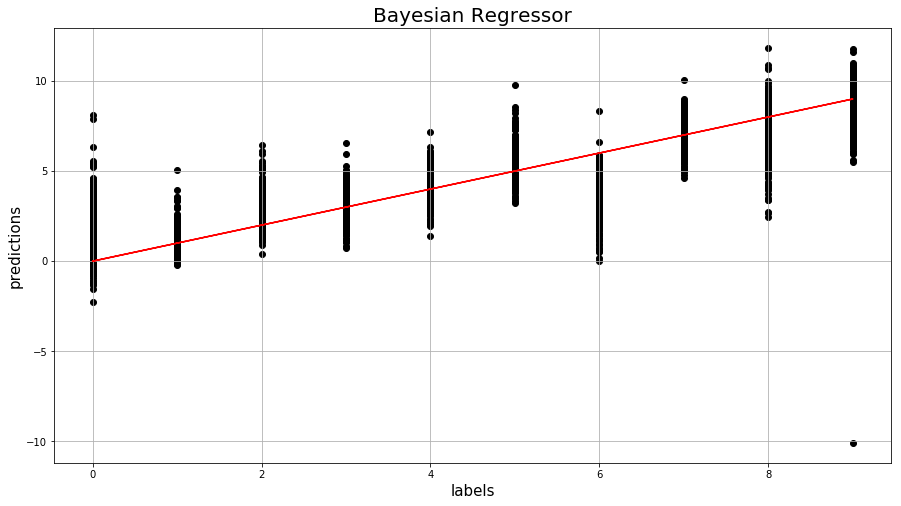

The mean-sqaured error of the naive bayes regressor is : 2.453581796945067
The accuracy of the naive bayes classifier is : 0.3776
the confusion matrix of the mnist dataset is:
 [[ 52  44  60  47  26   7   2   0   2   0]
 [ 43 160  46   6   3   1   0   0   0   0]
 [  1  10  73  92  62  11   4   0   0   0]
 [  0  13  52 104  65  13   1   1   0   0]
 [  0   1   5  57 116  52  17   1   0   0]
 [  0   0   0   3  26 101  75  30   8   2]
 [  3  11  21  53  78  69  24   1   1   0]
 [  0   0   0   0   0  14  72 112  35   8]
 [  0   0   1   5   9  21  43  66  63  48]
 [  1   0   0   0   0   0   9  27  71 139]]


In [68]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(Mnist.drop(columns='label').values)

labels=Mnist['label'].values
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
Bayes=BayesianRegressor()
Bayes.fit(X_train,y_train)       
predictions=Bayes.predict(X_test)
discrete_predictions=discretize(predictions,10)
scatter(predictions,y_test)
print("The mean-sqaured error of the naive bayes regressor is :",mse(y_test, predictions))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, discrete_predictions))
print("the confusion matrix of the mnist dataset is:\n",confusion_matrix(y_test , discrete_predictions,10))

#### Cifar Dataset

C:\Users\Alaa Boukhary\Anaconda3\envs\tf15\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


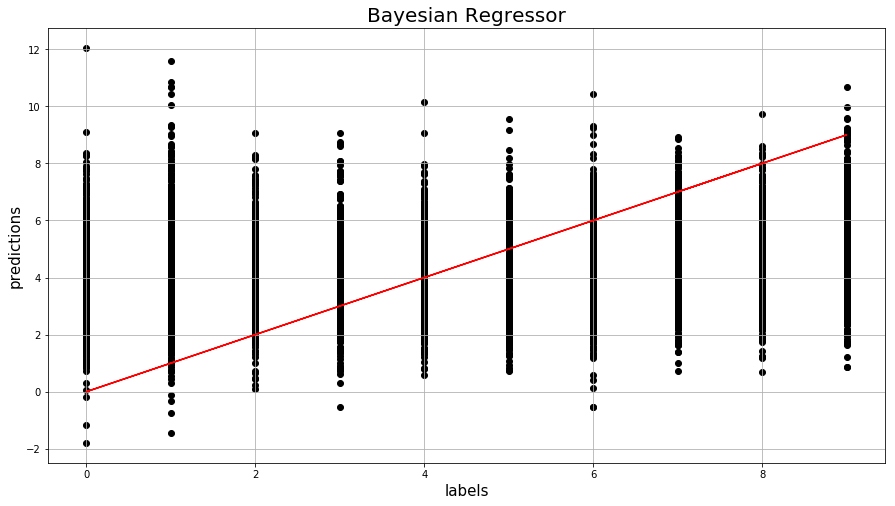

The mean-sqaured error of the naive bayes regressor is : 8.35044859644549
The accuracy of the naive bayes classifier is : 0.11176
the confusion matrix of the Cifar dataset is:
 [[  5  18  80 293 467 303  96  29   9   2]
 [  6  17  75 219 385 310 174  51  19  15]
 [  4   7  50 209 453 326 102  17   7   1]
 [  2  13  41 206 449 350 125  18   9   4]
 [  0   9  44 196 493 380 117  24   5   2]
 [  0   9  52 227 457 329 125  25   8   2]
 [  4   6  41 147 408 428 181  52   8   5]
 [  0   4  33 146 351 349 228  85  21   3]
 [  0   5  24 106 389 486 215  32  12   2]
 [  0   3  23 107 246 407 291 126  37  19]]


In [464]:
minmax=preprocessing.MinMaxScaler()
features=minmax.fit_transform(X)
labels=np.array([np.argmax(t) for t in Y])
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25)
Bayes=BayesianRegressor()
Bayes.fit(X_train,y_train)       
predictions=Bayes.predict(X_test)
discrete_predictions=discretize(predictions,10)
scatter(predictions,y_test)
print("The mean-sqaured error of the naive bayes regressor is :",mse(y_test, predictions))
print("The accuracy of the naive bayes classifier is :",accuracy_score(y_test, discrete_predictions))
print("the confusion matrix of the Cifar dataset is:\n",confusion_matrix(y_test , discrete_predictions,10))

### e. Performance of the Regressor

* As we saw when we descritized the output of the classifier and calculated its accuracy it gave very worse results compared to the Naive Bayes classifier so apparently using a regressor for classification is not a good idea.
* One can argue that the descritization method used is not good and maybe we should use intervals instead for each class, however looking at both plots obtained for datasets we can see that the outputs of each class are hugely overlapping so using other methods for descritization will not make the results any better.
* The following table summarizes the accuracies obtained for both classifiers/regressors on both datasets.

|Accuracy |Naive Bayes Classifier | Naive Linear Regressor |
|---------|-----------------------|------------------------|
| MNIST   |       0.5696          |          0.3776        |  
| CIFAR   |       0.28928         |          0.11176       |


### f. Limitation of The Classifier 

* When using linear regression in this problem we supposed that the output is linearly dependent on the pixels' values and that pixels are independent which is not the case as discussed in the previous classifier.
* Since the regressor gave the images of different classes overlapping outputs it confirms that the relation between pixels and and class can't be assumed linear.
